<a href="https://colab.research.google.com/github/GirikratnaSharma/Brain-Tumor-Detection/blob/master/Brain_Tumor_Detection_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection Using a Convolutional Neural Network

## Import Necessary Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [ ]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

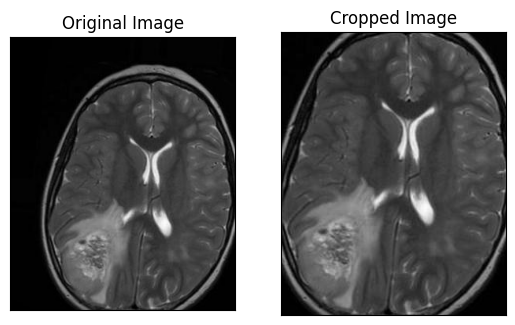

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/Brain_tumour_dataset_augmented/yes/aug_Y100_0_3403.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread('/content/drive/MyDrive/Brain_tumour_dataset_augmented/yes/aug_Y100_0_2812.jpg')
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
augmented_path = '/content/drive/MyDrive/Brain_tumour_dataset_augmented'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = '/content/drive/MyDrive/Brain_tumour_dataset_augmented/yes'
augmented_no = '/content/drive/MyDrive/Brain_tumour_dataset_augmented/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1812
X shape is: (1812, 240, 240, 3)
y shape is: (1812, 1)


As we see, we have 1812 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

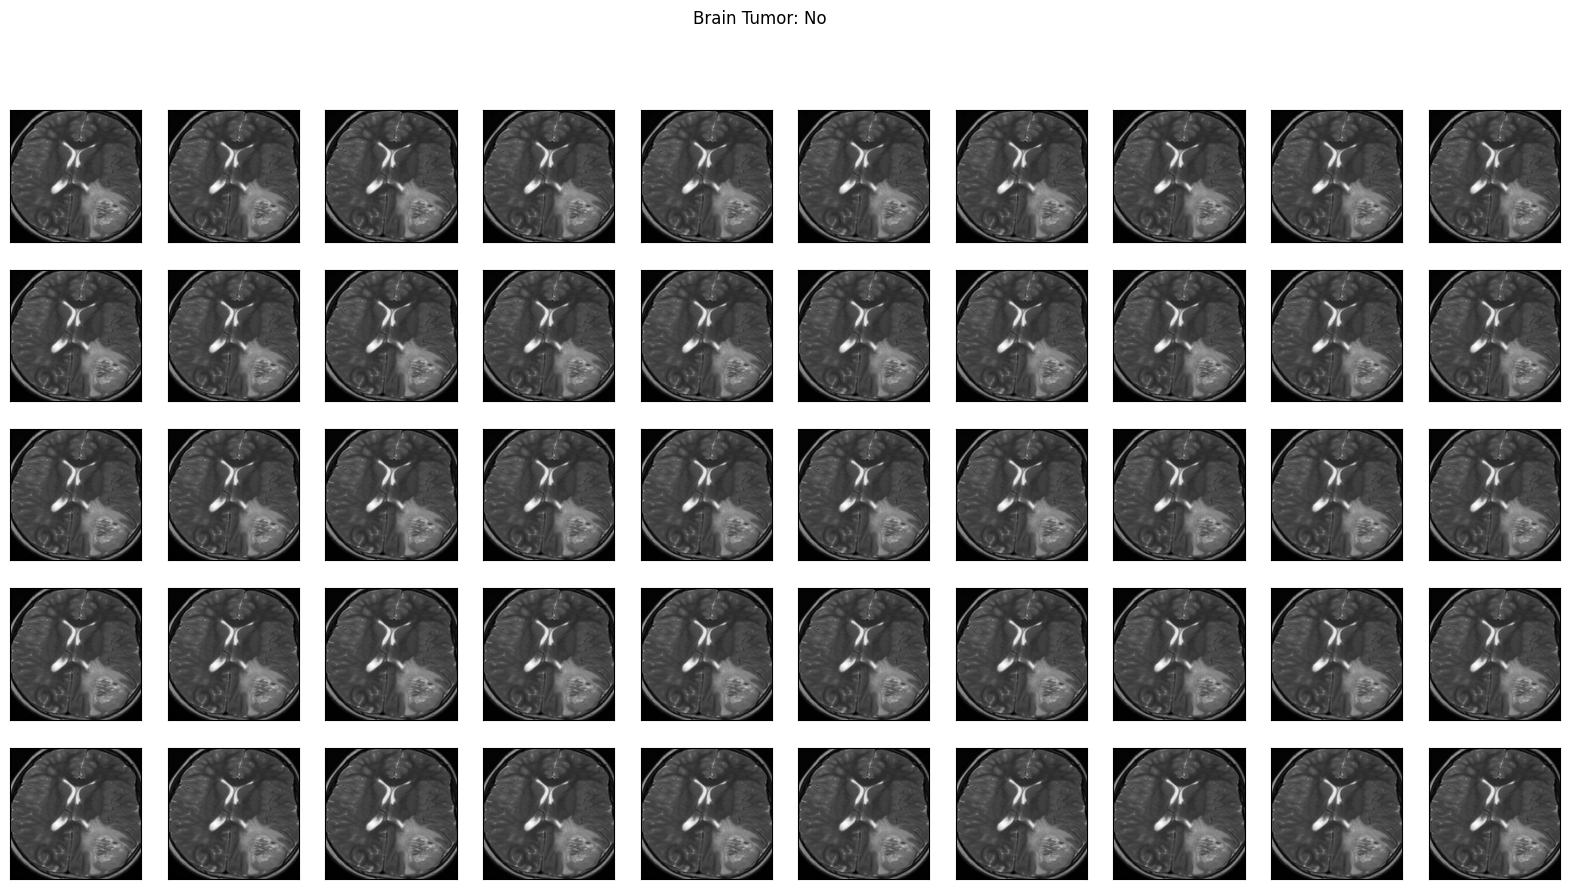

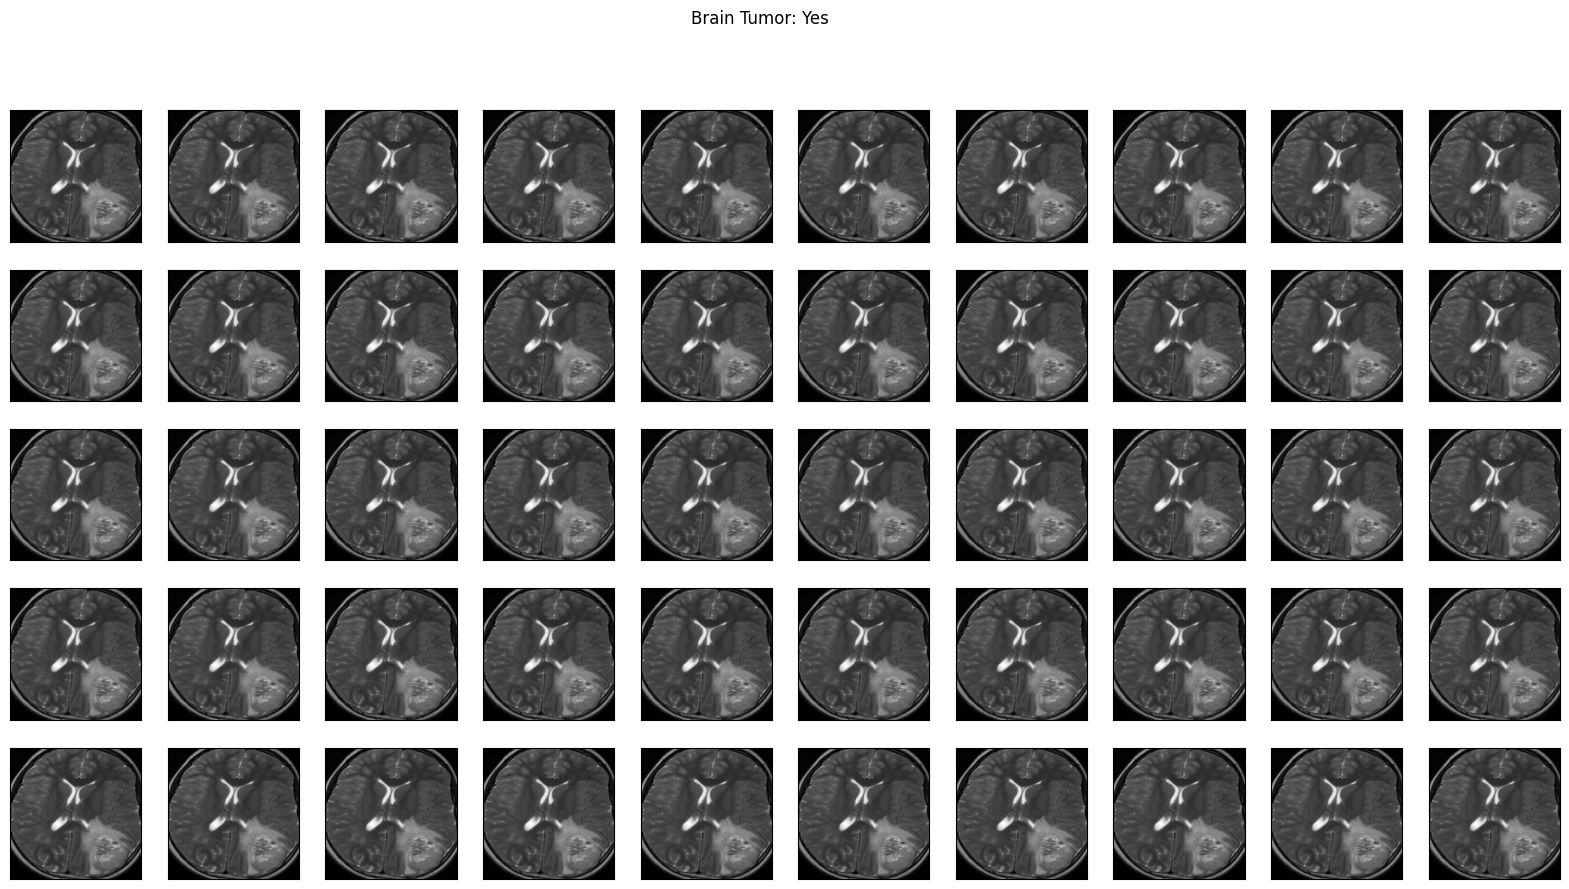

In [ ]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [ ]:
def split_data(X, y, test_size=0.2):



    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1268
number of development examples = 272
number of test examples = 272
X_train shape: (1268, 240, 240, 3)
Y_train shape: (1268, 1)
X_val (dev) shape: (272, 240, 240, 3)
Y_val (dev) shape: (272, 1)
X_test shape: (272, 240, 240, 3)
Y_test shape: (272, 1)


In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

# Build the model

In [ ]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)        0         
__________

Compile the model:

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [ ]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/10
1445/1445 [==============================] - 434s 300ms/step - loss: 0.8331 - acc: 0.5945 - val_loss: 0.6829 - val_acc: 0.4968
Epoch 2/10
1445/1445 [==============================] - 463s 320ms/step - loss: 0.4817 - acc: 0.7668 - val_loss: 0.6342 - val_acc: 0.6742
Epoch 3/10
1445/1445 [==============================] - 471s 326ms/step - loss: 0.4361 - acc: 0.8069 - val_loss: 0.5294 - val_acc: 0.8065
Epoch 4/10
1445/1445 [==============================] - 465s 322ms/step - loss: 0.3641 - acc: 0.8574 - val_loss: 0.6092 - val_acc: 0.6323
Epoch 5/10
1445/1445 [==============================] - 457s 316ms/step - loss: 0.3940 - acc: 0.8339 - val_loss: 0.4689 - val_acc: 0.7742
Epoch 6/10
1445/1445 [==============================] - 452s 313ms/step - loss: 0.3154 - acc: 0.8692 - val_loss: 0.4448 - val_acc: 0.7806
Epoch 7/10
1445/1445 [==============================] - 465s 322ms/step - loss: 0.2776 - acc: 0.8872 - val_loss: 0.4747 - val

Let's train for a few more epochs:

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1445 samples, validate on 310 samples
Epoch 1/3
1445/1445 [==============================] - 431s 299ms/step - loss: 0.2065 - acc: 0.9239 - val_loss: 0.3357 - val_acc: 0.8871
Epoch 2/3
1445/1445 [==============================] - 432s 299ms/step - loss: 0.1811 - acc: 0.9363 - val_loss: 0.3529 - val_acc: 0.8516
Epoch 3/3
1445/1445 [==============================] - 425s 294ms/step - loss: 0.1827 - acc: 0.9287 - val_loss: 0.4038 - val_acc: 0.8323
Elapsed time: 0:21:29.4


Concretely, the model at the 13th iteration with validation accuracy of 88%

In [ ]:
#Tried the same with overfitting for VGG-16 model with it's model summary


from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model


def build_vgg_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input1 = Input(input_shape) # shape=(?, 240, 240, 3)

    # Preprocess the input using VGG16's preprocess_input function
    X = Lambda(preprocess_input)(X_input1)

    # Load the VGG16 model (include_top=False means we don't include the final fully connected layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=X)

    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add your custom head on top of the pre-trained VGG16 base
    X = Flatten()(base_model.output)
    X = Dense(1, activation='softmax', name='fc')(X) # shape=(?, 1)

    # Create the model
    model2 = Model(inputs=X_input1, outputs=X, name='BrainDetectionVGGModel')

    return model2

In [ ]:
IMG_SHAPE2 = (240, 240, 3)

#IMG_SIZE = (240,240)

model2 = build_vgg_model(IMG_SHAPE2)

model2.summary()

Model: "BrainDetectionVGGModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 lambda_5 (Lambda)           (None, 240, 240, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120

In [ ]:
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping


In [ ]:
model2.compile(optimizer=RMSprop(lr=1.25e-4), loss='binary_crossentropy', metrics=['accuracy'])
history2 = cnnModel.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
41/41 [==============================] - 38s 909ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
41/41 [==============================] - 40s 976ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
41/41 [==============================] - 37s 914ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
41/41 [==============================] - 41s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
41/41 [==============================] - 39s 946ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
41/41 [==============================] - 38s 923ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
# Make predictions on test data
Y_prediction = cnnModel.predict(X_test)

# Convert predictions to binary values (0 or 1)
Y_pred_classes = (Y_prediction > 0.5).astype(int)

# Convert true labels to binary values (0 or 1)
Y_true = Y_test.astype(int)



12/12 [==============================] - 3s 212ms/step


In [ ]:
# Classification Report
print(classification_report(Y_true, Y_pred_classes))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       363

    accuracy                           1.00       363
   macro avg       1.00      1.00      1.00       363
weighted avg       1.00      1.00      1.00       363

